# Let's get rid of all the imports right away

In [65]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Basic analysis of the data

In [32]:
df = pd.read_csv("dschallenge.csv")
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


In [33]:
df.shape

(5000, 7)

# No null values - good news

In [34]:
df.isna().sum()

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

In [35]:
df.shop_id.nunique()

100

# 301 unique users making over 5000 orders 

In [36]:
df.user_id.nunique()

301

# Just looking at the first 15 rows, we calculate the Naive AOV to add up to 215.27 which seems to be more representative than an AOV over $3000 for shoes

In [160]:
frame = df[:15][['order_amount','total_items']]
print(frame)
naive_shoe_value = frame['order_amount'].sum()/len(frame['total_items'])
print(f'Naive average order value is {naive_shoe_value.round(2)}')

    order_amount  total_items
0            224            2
1             90            1
2            144            1
3            156            1
4            156            1
5            138            1
6            149            1
7            292            2
8            266            2
9            146            1
10           322            2
11           322            2
12           266            2
13           111            1
14           447            3
Naive average order value is 215.27


# Grouping based on shop_id and analysing

In [37]:
shop_order_df = df[['shop_id','order_amount']].groupby('shop_id',sort=False).sum()
print(shop_order_df['order_amount'].sum() == df['order_amount'].sum())
shop_order_df.describe()


True


,order_amount
count,1.000000e+02
mean,1.572564e+05
std,1.216218e+06
min,6.840000e+03
25%,1.293050e+04
50%,1.488750e+04
75%,1.760000e+04
max,1.199018e+07


# Analysing based on shop_id and analysing

In [38]:
shop_item_df = df[['shop_id','total_items']].groupby('shop_id',sort=False).sum()
print(shop_item_df.total_items.sum() == df.total_items.sum())
shop_item_df.describe()

True


,total_items
count,100.000000
mean,439.360000
std,3396.366111
min,67.000000
25%,88.000000
50%,100.000000
75%,111.250000
max,34063.000000


# Attemping to study rolling means of the order_amount on 30,20,15,10,5 periods

In [44]:
print(df['order_amount'].rolling(window=30).mean().describe())
print(df['order_amount'].rolling(window=20).mean().describe())
print(df['order_amount'].rolling(window=15).mean().describe())
print(df['order_amount'].rolling(window=10).mean().describe())
print(df['order_amount'].rolling(window=5).mean().describe())

count     4971.000000
mean      3095.884664
std       7300.053728
min        215.100000
25%        293.233333
50%        320.666667
75%       1161.833333
max      47219.500000
Name: order_amount, dtype: float64
count     4981.000000
mean      3127.940042
std       9009.244468
min        199.100000
25%        286.200000
50%        315.100000
75%        372.950000
max      70688.900000
Name: order_amount, dtype: float64
count     4986.000000
mean      3153.296791
std      10391.867924
min        194.466667
25%        279.200000
50%        312.733333
75%        362.183333
max      94107.133333
Name: order_amount, dtype: float64
count     4991.000000
mean      3150.381206
std      12804.680015
min        172.800000
25%        270.600000
50%        308.200000
75%        356.200000
max      75804.200000
Name: order_amount, dtype: float64
count      4996.000000
mean       3147.455564
std       18304.664983
min         136.800000
25%         254.400000
50%         301.600000
75%         358.40

# Plotting Box Plot to visualise the order_amount - clearly there are outliers that we need to fix

<AxesSubplot:>

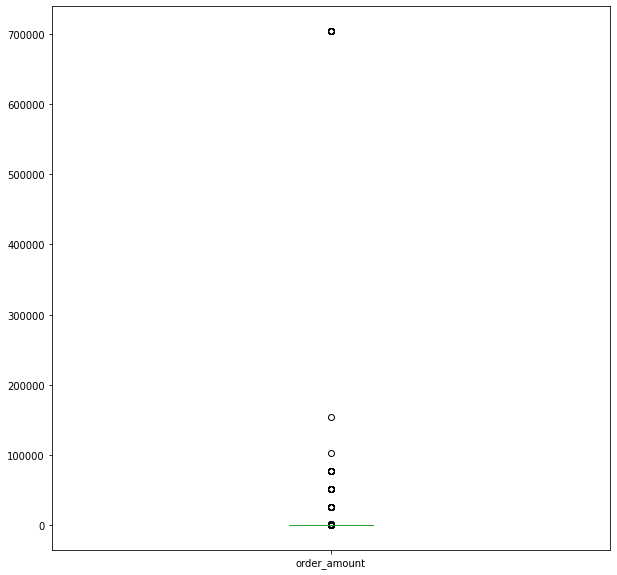

In [60]:
df['order_amount'].plot(kind='box',figsize=(10,10))

# But first let's plot a normal distribution over the histogram to see how skewed our data is - quite right skewed

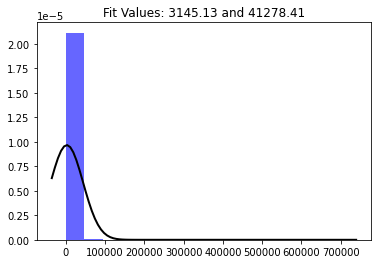

In [75]:
hist_data = df['order_amount']
mu, std = norm.fit(hist_data)
plt.hist(hist_data, bins=15, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

# Let's start with some metrics that are often used in analysing ecommerce data - clearly none of the methods are useful/ can be used as a viable metric for our data.

In [78]:
average_order_value  = df['order_amount'].sum()/len(df)
print(f'The AOV value is ${average_order_value}`')

The AOV value is $3145.128`


In [84]:
conversion_rate = len(df)/df.user_id.nunique()
print(f'Conversion Rate is ${conversion_rate}')

Conversion Rate is $16.611295681063122


In [173]:
revenue_per_user = int(df['order_amount'].sum()/df.user_id.nunique())
print(f'Revenue Per User is {revenue_per_user}')

Revenue Per User is 52244


# Time to find the outliers and to deal with them - we use IQR to determine them

In [98]:
data = df['order_amount'].sort_values(ascending=True)
q75, q25 = np.percentile(data,[75,25])
iqr = q75 - q25 
# [Q1 -1.5*IQR : Q3+1.5*IQR]
count = 0 
lowerBound = q25 - 1.5 * iqr 
upperBound = q75 + 1.5 * iqr
for row in data:
    if row < lowerBound or row > upperBound:
        count += 1

print(f' ${(count/len(data))*100} percent of the data are outliers')


 $2.82 percent of the data are outliers


# Creating a new DataFrame setting the outliers to NaNs for further analysis

In [117]:
data_df = pd.DataFrame(data)
data_df.order_amount = data_df.order_amount.astype(float)
print(data_df.columns)
for i, row in data_df[:].iterrows():
    val = row['order_amount']
    if val < lowerBound or val > upperBound:
        data_df.at[i, 'order_amount'] = np.nan
# print(data_df.isna().sum())
    

    

Index(['order_amount'], dtype='object')


# We realize that the entire data has 2% outliers but those outliers result in over 90% of the revenue

In [122]:
# lets figure out what percentage of the revenue the outliers contribute to
total_revenue = df.order_amount.sum()
total_revenue_without_outliers = data_df.order_amount.sum()
diff = total_revenue - total_revenue_without_outliers
percent_diff = (diff / total_revenue)*100
print(f'There are {count} outliers, they contribute ${diff} to the revenue which is {percent_diff} percent of the total revenue')

There are 141 outliers, they contribute 14298477.0$ to the revenue which is 90.92461101742123 percent of the total revenue


# Generating AOV for the data without the outliers we get 293.7 as the AOV value but this still seems to be quite high compared to the initial naive value for 15 rows

In [149]:
data_df.dropna(axis=0, inplace=True)
aov_without_outliers = data_df['order_amount'].sum()/len(data_df)
aov_without_outliers


293.7153735336489

# Sorting the DataFrame by the DateTime column

In [170]:
time_df = df.sort_values(by='created_at',ascending=True)

# Generating AOV over rolling 30 day period and confirming that it is in the same range as the challenge prompt

In [169]:
order_counts_rolling_sum = time_df.rolling(30).sum()
order_counts_rolling_sum = order_counts_rolling_sum[29:]
order_counts_rolling_sum['order_amount'].divide(30).round(2).mean()

3161.72108026554

# Proposing a new metric to use median order value 

In [175]:
order_counts_rolling_median = time_df.rolling(30).sum()
order_counts_rolling_median = order_counts_rolling_median[29:]
order_counts_rolling_median['order_amount'].divide(30).round(2).median()

319.47